In [1]:
import datetime as dt
import joblib
import pickle
import copy
import math
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.path as mpath
import cartopy
import cartopy.crs as ccrs
import cartopy.feature
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import cartopy.feature as cf
import shapely.geometry as sgeom
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from shapely import geometry

from sklearn.decomposition import PCA
from scipy import stats
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics.pairwise import euclidean_distances
# import statsmodels.api as sm
from scipy.stats import linregress
from sklearn.metrics import accuracy_score

from multiprocessing import Pool
from scipy.optimize import linear_sum_assignment

In [2]:
path_origins = '/glade/derecho/scratch/jhayron/Data4WRsClimateChange/ProcessedDataReanalyses/'
name_reanalysis = 'ERA5'
anoms_standardized = xr.open_dataset(f'{path_origins}Z500Anoms_{name_reanalysis}.nc')

In [3]:
var_name = 'Z_anom'
z500_anoms_flattened = anoms_standardized.stack(flat=('lat','lon')).transpose('time','flat')[var_name]
z500_anoms_flattened_training = copy.deepcopy(z500_anoms_flattened)

In [4]:
path_pcs = '/glade/derecho/scratch/jhayron/Data4WRsClimateChange/PCs_Z500/'
pca_obj = joblib.load(f'{path_pcs}PCs_{name_reanalysis}.pca_obj')
pcs = pd.read_csv(f'{path_pcs}/PCs_{name_reanalysis}_corrected.csv', 
                                     index_col=0, parse_dates=True, names=np.arange(0,12),skiprows=1)
z500_anoms_transformed = pca_obj.transform(z500_anoms_flattened_training) #exactly equal to pcs.values

# Assess K

In [5]:
## function to run the kmeans algorithm with one specific seed
def run_kmeans(params_temp):
    data, seed, k, n_init_internal = params_temp
    kmeans = KMeans(
        n_clusters=k, 
        init='k-means++', 
        n_init=n_init_internal, 
        random_state=seed
    )
    kmeans.fit(data)
    return {
        "inertia": kmeans.inertia_,
        "cluster_centers": kmeans.cluster_centers_,
        "labels": kmeans.labels_
    }

In [6]:
data4clustering = copy.deepcopy(z500_anoms_transformed)
random_seed = 0
n_init_internal = 50

2025-01-30 12:15:24.061513
2025-01-30 12:15:28.610035


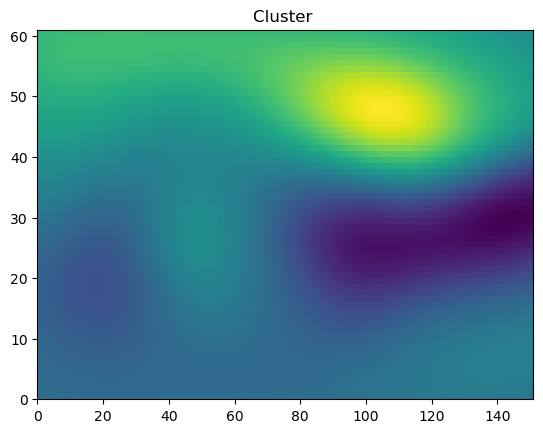

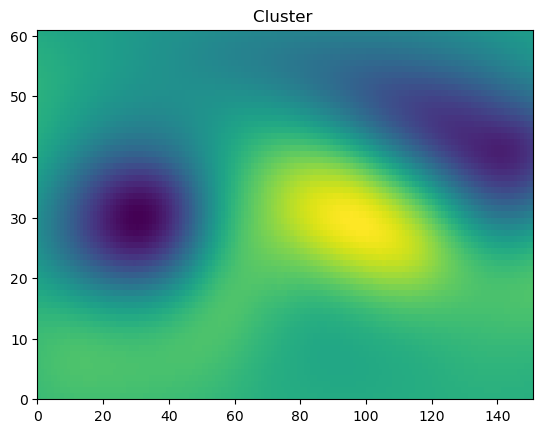

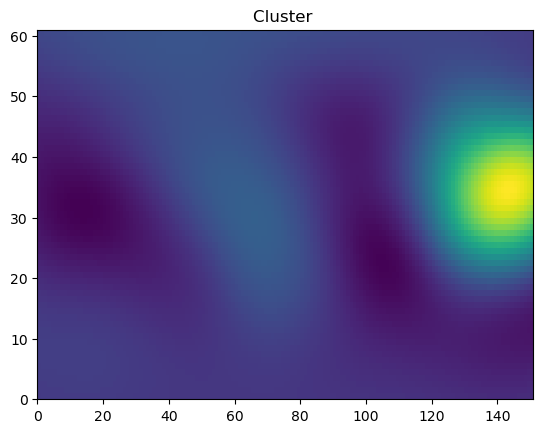

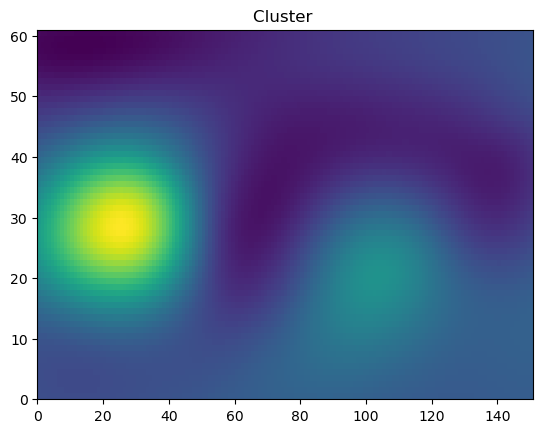

In [7]:
## Some speed tests:
print(dt.datetime.now())
results_example = run_kmeans((data4clustering,random_seed,4,n_init_internal)) # (data,seed,k,n_init_internal)
print(dt.datetime.now())

def convert_from_pcs_to_spatial(a,original_piece_of_data):
    # print(original_piece_of_data)
    original_piece_of_data.data = pca_obj.inverse_transform(a)
    # print(original_piece_of_data)
    return original_piece_of_data.unstack('flat')
    
for ki in range(4):
    example_cluster = convert_from_pcs_to_spatial(results_example['cluster_centers'][ki],
                                        copy.deepcopy(z500_anoms_flattened_training.isel(time=0)))
    plt.pcolormesh(example_cluster)
    plt.title('Cluster ')
    plt.show()

In [8]:
def compute_classifiability(data4clustering, k, n_partitionings, pca_obj,n_processes_multiprocessing,n_init_internal=1):
    params = [(data4clustering, seed_i,k,n_init_internal) for seed_i in range(n_partitionings)]
    # Create a pool of workers and run KMeans in parallel
    with Pool(processes=n_processes_multiprocessing) as pool: ### SPECIFY NUMBER OF PROCESSES
        results_kmeans = pool.map(run_kmeans, params)
    
    ## compute classifiability according to L23 and MV95
    ## (https://journals.ametsoc.org/view/journals/clim/36/20/JCLI-D-23-0214.1.xml#bib39)
    ## 
    centroids_inits = []
    for init in range(n_partitionings):
        centroids_inits.append(results_kmeans[init]['cluster_centers'])
    centroids_inits = np.array(centroids_inits)
    
    min_corrs = []
    for init0 in range(n_partitionings):
        min_corrs_temp = []
        for init1 in range(n_partitionings):
            if init0==init1:
                continue
            else:
                # corr_matrix = np.corrcoef(centroids_inits[init0],centroids_inits[init1])[:k,-k:]
                corr_matrix = np.corrcoef(pca_obj.inverse_transform(centroids_inits[init0]),
                                          pca_obj.inverse_transform(centroids_inits[init1]))[:k,-k:]
                cost_matrix = -corr_matrix
                ## This line assigns each cluster from group 1 to the most similar cluster from group zero
                ## solving the assignment problem using the Jonker-Volgenant algorithm
                row_ind, col_ind = linear_sum_assignment(cost_matrix) # https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.linear_sum_assignment.html
                matched_clusters = list(zip(row_ind, col_ind))
                matched_correlations = corr_matrix[row_ind, col_ind]
                # matched_correlations = corr_matrix.max(axis=0)
                min_corr = np.min(matched_correlations)
                min_corrs_temp.append(min_corr)
    
        min_corrs.append(min_corrs_temp)
    
    similarity = np.array(min_corrs) ## This is the similarity
    classifiability = np.mean(min_corrs)
    # 1. Choose the reference partition (with the maximum average similarity value)
    pos_reference_partition = similarity.mean(axis=1).argmax()
    ref_centroids = centroids_inits[pos_reference_partition]
    return similarity, classifiability, ref_centroids, pos_reference_partition

def compute_reproducibility(data4clustering,ref_centroids_temp,
                            k,n_subsets,n_partitionings,pca_obj,n_processes_multiprocessing,n_init_internal):
    ## Draw n_subsets random half-length subsamples from the atmospheric data and compute the reproducibility index
    ## according to MV95

    reproducibility_subsets = []
    classifiability_subsets = []
    for seed_temp in range(n_subsets):
        # print(seed_temp)
        np.random.seed(seed_temp)
        # Select half of the data randomly
        random_indices = np.random.choice(np.arange(len(data4clustering)),size=int(len(data4clustering)/2),replace=False)
        data_subset_temp = data4clustering[random_indices]
        ## Compute similarity on the subset to extract the reference/best clustering
        similarity_temp_subset, classifiability_temp_subset, \
            ref_centroids_temp_subset, seed_ref_temp_subset = compute_classifiability(
                               data_subset_temp,
                               k=k,
                               n_partitionings=n_partitionings,
                               pca_obj=pca_obj,
                               n_processes_multiprocessing=n_processes_multiprocessing,n_init_internal=n_init_internal)
        ## Correlation matrix between the clusters of  subset and the full set
        corr_matrix = np.corrcoef(pca_obj.inverse_transform(ref_centroids_temp),
                                  pca_obj.inverse_transform(ref_centroids_temp_subset))[:k,-k:]
        cost_matrix = -corr_matrix
        ## This line assigns each cluster from group 1 to the most similar cluster from group zero
        ## solving the assignment problem using the Jonker-Volgenant algorithm
        row_ind, col_ind = linear_sum_assignment(cost_matrix) # https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.linear_sum_assignment.html
        matched_clusters = list(zip(row_ind, col_ind))
        matched_correlations = corr_matrix[row_ind, col_ind]
        reproducibility_subsets.append(matched_correlations)
        classifiability_subsets.append(classifiability_temp_subset)

    return np.array(reproducibility_subsets), np.array(classifiability_subsets)

In [9]:
### Test to see the effect of internal n_init in classifiability
k=4
n_partitionings=50
for n_init_internal in [1,3,5,10,25]:
    print(dt.datetime.now())
    similarity_test, classifiability_test, _, _=\
                            compute_classifiability(z500_anoms_transformed,
                            k=k,
                            n_partitionings=n_partitionings,
                            pca_obj=pca_obj,
                            n_processes_multiprocessing=50,
                            n_init_internal=n_init_internal)
    print(n_init_internal,classifiability_test)

2025-01-30 12:15:29.025236
1 0.35364866446205
2025-01-30 12:15:31.425686
3 0.42278021139180083
2025-01-30 12:15:34.190930
5 0.6145563567411758
2025-01-30 12:15:37.346955
10 0.9150346192726893
2025-01-30 12:15:41.327288
25 0.969860145172476


In [10]:
print(dt.datetime.now())

2025-01-30 12:15:46.618826


In [11]:
n_init_internal = 50
n_partitionings = 100  #50 in MV95 and 1000 L23
n_processes_multiprocessing = 100
n_subsets_reproducibility = 100 #100 MV95 1000 L23

In [12]:
dic_results_best_k = {}
dic_results_best_k['similarity'] = []
dic_results_best_k['classifiability'] = []
dic_results_best_k['ref_centroids'] = []
dic_results_best_k['seed_ref_centroids'] = []
dic_results_best_k['reproducibility_subsets'] = []
dic_results_best_k['reproducibility'] = []
dic_results_best_k['classifiability_subsets'] = []
dic_results_best_k['db_index'] = []
dic_results_best_k['max_intercluster_corr'] = []

print('k','classifiability','reproducibility','dbi','max_intercluster_corr')

for k in range(2,11):
# for k in [3]:
    print(dt.datetime.now())
    ## Compute classifiability and find the best clustering
    similarity_temp, classifiability_temp, ref_centroids_temp, seed_ref_temp = compute_classifiability(
                           data4clustering,
                           k=k,
                           n_partitionings=n_partitionings,
                           n_init_internal=n_init_internal,
                           pca_obj=pca_obj,
                           n_processes_multiprocessing=n_processes_multiprocessing)
    # run_kmeans((copy.deepcopy(z500_anoms_transformed),seed_ref_temp,5)) If I need to re-run the reference partitioning
    
    ## Compute reproducibility and classifiability for each subset of data
    reproducibility_subsets_temp, classifiability_subsets_temp = compute_reproducibility(
                            data4clustering,
                            ref_centroids_temp,
                            k,
                            n_subsets=n_subsets_reproducibility,
                            n_init_internal=n_init_internal,
                            pca_obj=pca_obj,
                            n_processes_multiprocessing=n_processes_multiprocessing,
                            n_partitionings=n_partitionings)
    reproducibility_temp = reproducibility_subsets_temp.mean(axis=0)
    
    results_kmeans_best_model = run_kmeans((copy.deepcopy(z500_anoms_transformed),seed_ref_temp,k,n_init_internal)) # (data,seed,k,n_init_internal)
    
    ## Compute the Davies-Bouldin Score 
    dbi = davies_bouldin_score(copy.deepcopy(z500_anoms_transformed), results_kmeans_best_model['labels'])

    ## Compute the maximum intercluster correlation
    correlation_matrix = np.corrcoef(results_kmeans_best_model['cluster_centers'])
    np.fill_diagonal(correlation_matrix, np.nan)
    max_intercluster_corr = np.nanmax(correlation_matrix)

    dic_results_best_k['similarity'].append(similarity_temp)
    dic_results_best_k['classifiability'].append(classifiability_temp)
    dic_results_best_k['ref_centroids'].append(ref_centroids_temp)
    dic_results_best_k['seed_ref_centroids'].append(seed_ref_temp)
    dic_results_best_k['reproducibility_subsets'].append(reproducibility_subsets_temp)
    dic_results_best_k['reproducibility'].append(reproducibility_temp)
    dic_results_best_k['classifiability_subsets'].append(classifiability_subsets_temp)
    dic_results_best_k['db_index'].append(dbi)
    dic_results_best_k['max_intercluster_corr'].append(max_intercluster_corr)
    print(k,classifiability_temp,reproducibility_temp,dbi,max_intercluster_corr)
    np.save('dic_results_best_k.npy',dic_results_best_k)

k classifiability reproducibility dbi max_intercluster_corr
2025-01-30 12:15:46.640244
2 0.9787489827616013 [0.58575151 0.59265691] 4.007839407565139 -1.0
2025-01-30 12:28:14.636754
3 0.9948807847650989 [0.87384562 0.91716882 0.91376125] 3.4445749170842945 -0.3952549950707112
2025-01-30 12:44:59.534671
4 0.9757390171499271 [0.73551358 0.80721224 0.74502763 0.72881159] 3.1081113288681044 -0.25275320664438744
2025-01-30 13:02:45.056131
5 0.9956645333528611 [0.98416294 0.95193891 0.96352609 0.96592962 0.97763632] 2.8858990131853313 -0.05569936501873025
2025-01-30 13:24:07.678633
6 0.8022242199087245 [0.97413461 0.50872807 0.9379141  0.67387417 0.81750445 0.7703253 ] 2.7179897957748573 -0.06729783459358393
2025-01-30 13:47:19.707603
7 0.860525907226111 [0.73791066 0.92272528 0.59146262 0.69598635 0.87519704 0.97847192
 0.84679835] 2.5849469231047637 0.05352223931385915
2025-01-30 14:13:19.000364
8 0.8989566433398964 [0.9514186  0.73564259 0.83201599 0.86188257 0.98118365 0.85961761
 0.6707

In [13]:
dic_results_best_k['similarity'] = np.array(dic_results_best_k['similarity'])
dic_results_best_k['classifiability'] = np.array(dic_results_best_k['classifiability'])
dic_results_best_k['classifiability_subsets'] = np.array(dic_results_best_k['classifiability_subsets'])
dic_results_best_k['seed_ref_centroids'] = np.array(dic_results_best_k['seed_ref_centroids'])
dic_results_best_k['db_index'] = np.array(dic_results_best_k['db_index'])
dic_results_best_k['max_intercluster_corr'] = np.array(dic_results_best_k['max_intercluster_corr'])
np.save('dic_results_best_k.npy',dic_results_best_k)

In [14]:
print(dt.datetime.now())

2025-01-30 15:38:43.419036


In [15]:
lower_bound_subsets_class = dic_results_best_k['classifiability_subsets'].min(axis=1)
upper_bound_subsets_class = dic_results_best_k['classifiability_subsets'].max(axis=1)

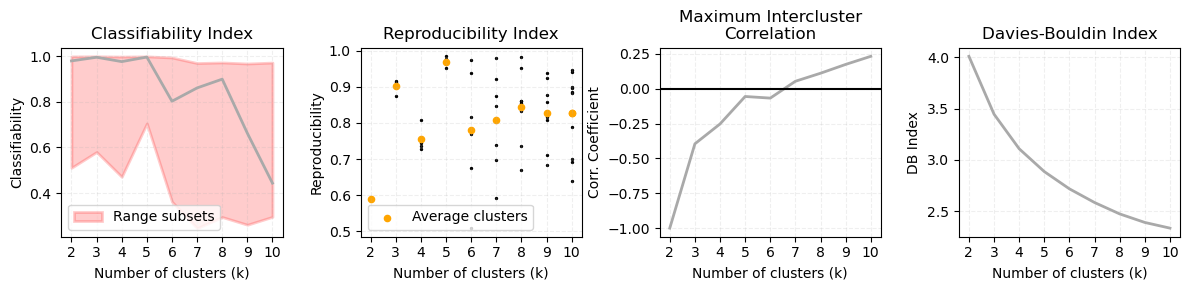

In [16]:
fig, axes = plt.subplots(1, 4, figsize=(12,3))

axes[0].plot(np.arange(2,11),dic_results_best_k['classifiability'],color='darkgray',lw=2)
axes[0].fill_between(np.arange(2,11),lower_bound_subsets_class,upper_bound_subsets_class,
                     color='red',lw=2,alpha=0.2,label='Range subsets')
axes[0].set_xlabel('Number of clusters (k)')
axes[0].set_title('Classifiability Index')
axes[0].set_ylabel('Classifiability')
axes[0].set_xticks(np.arange(2,11))
axes[0].grid(alpha=0.2,ls='--')
axes[0].legend()

for k in range(2,11):
    axes[1].scatter(np.repeat(k,k),
             dic_results_best_k['reproducibility'][k-2],color='k',s=2)
    axes[1].scatter(k,
             np.mean(dic_results_best_k['reproducibility'][k-2]),
                    color='orange',s=20)
axes[1].scatter(k,
         np.mean(dic_results_best_k['reproducibility'][k-2]),
                color='orange',s=20,label='Average clusters')
    # axes[1].axhline(0,color='k')
axes[1].set_xlabel('Number of clusters (k)')
axes[1].set_ylabel('Reproducibility')
axes[1].set_title('Reproducibility Index')
axes[1].set_xticks(np.arange(2,11))
axes[1].grid(alpha=0.2,ls='--')
axes[1].legend()

axes[2].plot(np.arange(2,11),dic_results_best_k['max_intercluster_corr'],color='darkgray',lw=2)
axes[2].axhline(0,color='k')
axes[2].set_xlabel('Number of clusters (k)')
axes[2].set_ylabel('Corr. Coefficient')
axes[2].set_title('Maximum Intercluster\nCorrelation')
axes[2].set_xticks(np.arange(2,11))
axes[2].grid(alpha=0.2,ls='--')

axes[3].plot(np.arange(2,11),dic_results_best_k['db_index'],color='darkgray',lw=2)
axes[3].set_xlabel('Number of clusters (k)')
axes[3].set_title('Davies-Bouldin Index')
axes[3].set_ylabel('DB Index')
axes[3].set_xticks(np.arange(2,11))
axes[3].grid(alpha=0.2,ls='--')

plt.tight_layout()
# plt.savefig(f'{path_figures}DBI.png',bbox_inches='tight')

In [17]:
from scipy.stats import multivariate_normal

# Assume X has shape (n_times, 12)
# n_times: number of time steps, 12: number of PCs

# Function to compute lag-0 covariance (C0)
def compute_covariance(data):
    """
    Computes the covariance matrix (C0) of the given data.
    data: numpy array of shape (n_times, num_pcs).
    """
    return np.cov(data, rowvar=False)  # Covariance along the PCs (columns)

# Function to compute lag-1 covariance (C1)
def compute_lagged_covariance(data):
    """
    Computes the lag-1 covariance matrix (C1) of the given data.
    data: numpy array of shape (n_times, num_pcs).
    """
    data_t = data[:-1, :]  # Time step t
    data_t1 = data[1:, :]  # Time step t+1
    return np.cov(data_t.T, data_t1.T)[:data.shape[1], data.shape[1]:]

# Function to generate a single synthetic time series
def generate_markov_process(A, Q, C0, steps, num_pcs, seed_temp):
    """
    Generate a synthetic time series following a first-order Markov process.
    """
    np.random.seed(seed_temp)
    # Initialize with random values from the stationary distribution
    X = np.random.multivariate_normal(mean=np.zeros(num_pcs), cov=C0)
    time_series = [X]
    
    for _ in range(steps - 1):
        # Generate noise
        noise = np.random.multivariate_normal(mean=np.zeros(num_pcs), cov=Q)
        # Compute next step
        X = np.dot(A, X) + noise  # Shape: (12,)
        time_series.append(X)
    
    return np.array(time_series)  # Shape: (steps, 12)

# Wrapper function for multiprocessing
def generate_one_variation(args):
    """
    Wrapper function to generate a single time series for multiprocessing.
    """
    A, Q, C0, steps, num_pcs, seed_temp = args
    return generate_markov_process(A, Q, C0, steps, num_pcs, seed_temp)

# Multiprocessing function to generate multiple variations
def generate_multiple_variations_multiprocessing(A, Q, C0, steps, num_pcs, n_variations,ncores):
    """
    Generate multiple variations using multiprocessing.
    """
    # Create arguments for each process
    args = [(A, Q, C0, steps, num_pcs, seed_temp) for seed_temp in range(n_variations)]
    
    # Use all available CPU cores
    n_cores = ncores ## SPECIFY # OF CORES
    with Pool(n_cores) as pool:
        all_variations = pool.map(generate_one_variation, args)
    
    return np.array(all_variations)  # Shape: (n_variations, steps, num_pcs)

(100, 30660, 12)
Diagonals: 
A original: [0.97037004 0.96884141 0.97165207 0.95827816 0.96193441 0.96464514
 0.95714503 0.96030628 0.95839645 0.95788485 0.95299473 0.9540253 ]
A synthetic: [0.96944927 0.96809108 0.97010262 0.9570885  0.96296094 0.96474582
 0.95568835 0.95986322 0.9586924  0.95787835 0.95557035 0.95284219]
Q original: [0.05338577 0.05018953 0.05377867 0.0729825  0.06751374 0.0677579
 0.07503285 0.06942448 0.07868027 0.07886926 0.08443866 0.08337497]
Q synthetic: [0.09622999 0.06652883 0.06666688 0.09463113 0.06733053 0.08103295
 0.08513699 0.06168783 0.08020787 0.08701121 0.08331378 0.08032002]
C1 original: [0.97037004 0.96884141 0.97165207 0.95827816 0.96193441 0.96464514
 0.95714503 0.96030628 0.95839645 0.95788485 0.95299473 0.9540253 ]
C1 synthetic: [0.92770411 0.95336009 0.95821549 0.9349331  0.96136078 0.95175987
 0.94698876 0.96871428 0.95690677 0.94883452 0.95425088 0.95702641]


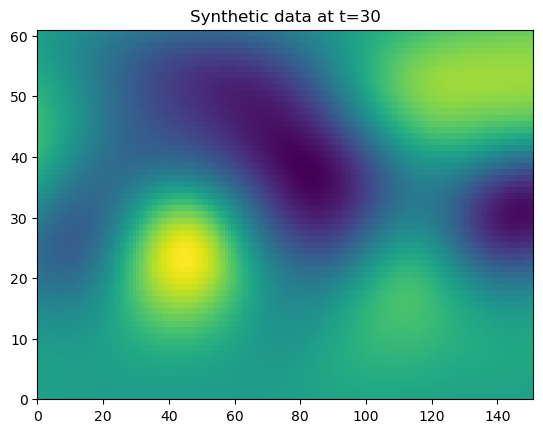

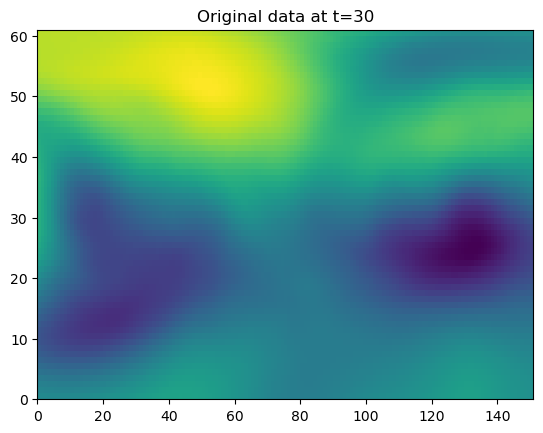

In [18]:
np.random.seed(0)
X = copy.deepcopy(z500_anoms_transformed)
n_times = len(X)  # Number of time steps per time series
num_pcs = X.shape[1]    # Number of PCs
n_variations = 100  # Number of random variations for the AR synthetic models: 100 in MV95 and L23

# Step 1: Compute Covariance Matrices
C0 = compute_covariance(X)  # Lag-0 covariance, shape: (12, 12)
C1 = compute_lagged_covariance(X)  # Lag-1 covariance, shape: (12, 12)

# Step 2: Compute Transition Matrix (A). Since X(t+1) = A.X(t) + w(t)), with w being the noise
# The diagonal of A is the lag-1 autocorrelation of each PC (non-noisy component) with itself
A = np.dot(C1, np.linalg.inv(C0))  # Shape: (12, 12)

# Step 3: Compute Noise Covariance (Q).
#each entry  Q{ij}  represents the covariance between the noise components  w_{i,t}  and  w_{j,t} 
#The noise vector drawn from a muktivariate normal distribution with mean zero and covariance Q
Q = C0 - np.dot(A, C1.T)  # Shape: (12, 12)

# Step 4: Generate synthetic data
all_synthetic_data = generate_multiple_variations_multiprocessing(A, Q, C0, n_times, num_pcs, 
                                                                  n_variations,n_processes_multiprocessing)
print(all_synthetic_data.shape)

## Sanity check: The diagonal of A, Q, and C0 with the synthetic data must be similar to those computed
## with the original data

X_synthetic = all_synthetic_data[3]
C0_synthetic = compute_covariance(X_synthetic)  # Lag-0 covariance, shape: (12, 12)
C1_synthetic = compute_lagged_covariance(X_synthetic)  # Lag-1 covariance, shape: (12, 12)
A_synthetic = np.dot(C1_synthetic, np.linalg.inv(C0_synthetic))  # Shape: (12, 12)
Q_synthetic = C0 - np.dot(A_synthetic, C1_synthetic.T)  # Shape: (12, 12)

print('Diagonals: ')
print('A original:',A.diagonal())
print('A synthetic:',A_synthetic.diagonal())
print('Q original:',Q.diagonal())
print('Q synthetic:',Q_synthetic.diagonal())
print('C1 original:',C1.diagonal())
print('C1 synthetic:',C1_synthetic.diagonal())

#Conclusion--courtesy of ChatGPT:
# 	•	Diagonals of  A  look reasonable and very close between the original and synthetic data, 
#indicating that the lag-1 autocorrelations are well preserved.
# 	•	Diagonals of  Q  show an increase in noise variance in the synthetic data, 
#which is typical and not necessarily a problem.
# 	•	Diagonals of  C_1  are slightly different between the original and synthetic data, 
#but these small deviations (e.g., values slightly less than 1) are normal due to the inherent randomness in generating synthetic data. 
#As long as the covariance structure is generally preserved, these small differences are expected.

# Overall, everything looks correct, and the differences you’re seeing are consistent 
#with the nature of synthetic data generation.

## Another sanity check: plot one example of synthetic data
def convert_from_pcs_to_spatial(a,original_piece_of_data):
    # print(original_piece_of_data)
    original_piece_of_data.data = pca_obj.inverse_transform(a)
    # print(original_piece_of_data)
    return original_piece_of_data.unstack('flat')
    
example_synthetic_data = convert_from_pcs_to_spatial(all_synthetic_data[0][3],
                                                    copy.deepcopy(z500_anoms_flattened_training.isel(time=3)))
plt.pcolormesh(example_synthetic_data)
plt.title('Synthetic data at t=30')
plt.show()

plt.pcolormesh(z500_anoms_flattened_training.isel(time=3).unstack('flat'))
plt.title('Original data at t=30')
plt.show()

In [19]:
classifiability_synthetic = []
for k in range(2,11):
    print(k)
    classifiability_synthetic_temp = []
    for s in range(len(all_synthetic_data)):
        ## Compute classifiability and find the best clustering
        similarity_temp, classifiability_temp, ref_centroids_temp, seed_ref_temp = compute_classifiability(
                               all_synthetic_data[s],
                               k=k,
                               n_partitionings=n_partitionings,
                               pca_obj=pca_obj,
                               n_processes_multiprocessing=n_processes_multiprocessing,
                               n_init_internal=n_init_internal)
        classifiability_synthetic_temp.append(classifiability_temp)
    classifiability_synthetic.append(classifiability_synthetic_temp)
    np.save('classifiability_synthetic.npy',np.array(classifiability_synthetic))

2
3
4
5
6
7
8
9
10


In [24]:
classifiability_synthetic = np.array(classifiability_synthetic)
lower_bound_synth_class = np.quantile(classifiability_synthetic,0.9,axis=1)
upper_bound_synth_class = np.quantile(classifiability_synthetic,0.10,axis=1)

lower_bound_subsets_class = np.quantile(dic_results_best_k['classifiability_subsets'],0.1,axis=1)
upper_bound_subsets_class = np.quantile(dic_results_best_k['classifiability_subsets'],0.9,axis=1)

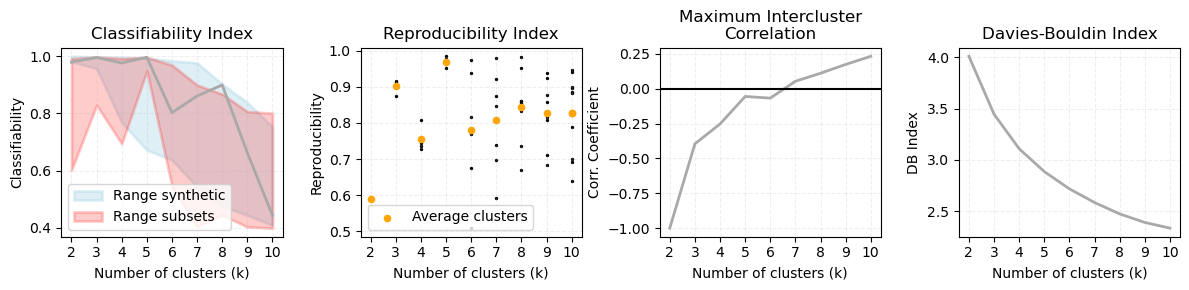

In [27]:
fig, axes = plt.subplots(1, 4, figsize=(12,3))

axes[0].fill_between(np.arange(2,11),lower_bound_synth_class, upper_bound_synth_class,
                     color='lightblue',lw=2,alpha=0.4,label='Range synthetic')
axes[0].fill_between(np.arange(2,11),lower_bound_subsets_class,upper_bound_subsets_class,
                     color='red',lw=2,alpha=0.2,label='Range subsets')
axes[0].plot(np.arange(2,11),dic_results_best_k['classifiability'],color='darkgray',lw=2)
axes[0].set_xlabel('Number of clusters (k)')
axes[0].set_title('Classifiability Index')
axes[0].set_ylabel('Classifiability')
axes[0].set_xticks(np.arange(2,11))
axes[0].grid(alpha=0.2,ls='--')
axes[0].legend()

for k in range(2,11):
    axes[1].scatter(np.repeat(k,k),
             dic_results_best_k['reproducibility'][k-2],color='k',s=2)
    axes[1].scatter(k,
             np.mean(dic_results_best_k['reproducibility'][k-2]),
                    color='orange',s=20)
axes[1].scatter(k,
         np.mean(dic_results_best_k['reproducibility'][k-2]),
                color='orange',s=20,label='Average clusters')
    # axes[1].axhline(0,color='k')
axes[1].set_xlabel('Number of clusters (k)')
axes[1].set_ylabel('Reproducibility')
axes[1].set_title('Reproducibility Index')
axes[1].set_xticks(np.arange(2,11))
axes[1].grid(alpha=0.2,ls='--')
axes[1].legend()

axes[2].plot(np.arange(2,11),dic_results_best_k['max_intercluster_corr'],color='darkgray',lw=2)
axes[2].axhline(0,color='k')
axes[2].set_xlabel('Number of clusters (k)')
axes[2].set_ylabel('Corr. Coefficient')
axes[2].set_title('Maximum Intercluster\nCorrelation')
axes[2].set_xticks(np.arange(2,11))
axes[2].grid(alpha=0.2,ls='--')

axes[3].plot(np.arange(2,11),dic_results_best_k['db_index'],color='darkgray',lw=2)
axes[3].set_xlabel('Number of clusters (k)')
axes[3].set_title('Davies-Bouldin Index')
axes[3].set_ylabel('DB Index')
axes[3].set_xticks(np.arange(2,11))
axes[3].grid(alpha=0.2,ls='--')

plt.tight_layout()
# plt.savefig(f'{path_figures}DBI.png',bbox_inches='tight')

# Just load and plot results

In [3]:
dic_results_best_k = np.load('dic_results_best_k.npy',allow_pickle=True)[()]

In [4]:
classifiability_synthetic = np.load('classifiability_synthetic.npy')

In [11]:
lower_bound_synth_class = np.quantile(classifiability_synthetic,0.9,axis=1)
upper_bound_synth_class = np.quantile(classifiability_synthetic,0.10,axis=1)

q25_synth_class = np.quantile(classifiability_synthetic,0.25,axis=1)
q75_synth_class = np.quantile(classifiability_synthetic,0.75,axis=1)

lower_bound_subsets_class = np.quantile(dic_results_best_k['classifiability_subsets'],0.1,axis=1)
upper_bound_subsets_class = np.quantile(dic_results_best_k['classifiability_subsets'],0.9,axis=1)

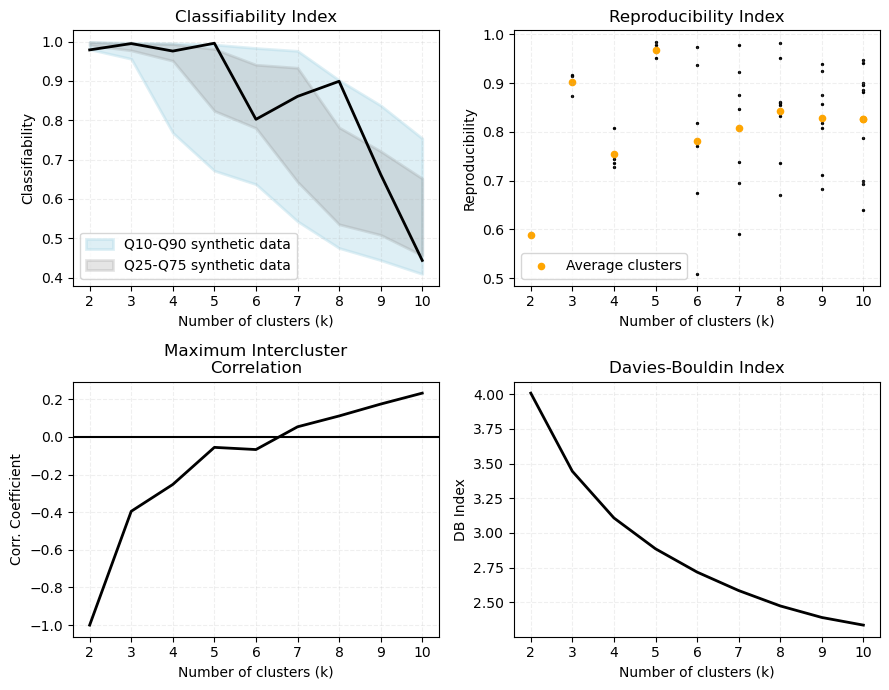

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(9,7))
axes = axes.flatten()

axes[0].fill_between(np.arange(2,11),lower_bound_synth_class, upper_bound_synth_class,
                     color='lightblue',lw=2,alpha=0.4,label='Q10-Q90 synthetic data')
axes[0].fill_between(np.arange(2,11),q25_synth_class,q75_synth_class,
                     color='gray',lw=2,alpha=0.2,label='Q25-Q75 synthetic data')
axes[0].plot(np.arange(2,11),dic_results_best_k['classifiability'],color='k',lw=2)
axes[0].set_xlabel('Number of clusters (k)')
axes[0].set_title('Classifiability Index')
axes[0].set_ylabel('Classifiability')
axes[0].set_xticks(np.arange(2,11))
axes[0].grid(alpha=0.2,ls='--')
axes[0].legend()

for k in range(2,11):
    axes[1].scatter(np.repeat(k,k),
             dic_results_best_k['reproducibility'][k-2],color='k',s=2)
    axes[1].scatter(k,
             np.mean(dic_results_best_k['reproducibility'][k-2]),
                    color='orange',s=20)
axes[1].scatter(k,
         np.mean(dic_results_best_k['reproducibility'][k-2]),
                color='orange',s=20,label='Average clusters')
    # axes[1].axhline(0,color='k')
axes[1].set_xlabel('Number of clusters (k)')
axes[1].set_ylabel('Reproducibility')
axes[1].set_title('Reproducibility Index')
axes[1].set_xticks(np.arange(2,11))
axes[1].grid(alpha=0.2,ls='--')
axes[1].legend()

axes[2].plot(np.arange(2,11),dic_results_best_k['max_intercluster_corr'],color='k',lw=2)
axes[2].axhline(0,color='k')
axes[2].set_xlabel('Number of clusters (k)')
axes[2].set_ylabel('Corr. Coefficient')
axes[2].set_title('Maximum Intercluster\nCorrelation')
axes[2].set_xticks(np.arange(2,11))
axes[2].grid(alpha=0.2,ls='--')

axes[3].plot(np.arange(2,11),dic_results_best_k['db_index'],color='k',lw=2)
axes[3].set_xlabel('Number of clusters (k)')
axes[3].set_title('Davies-Bouldin Index')
axes[3].set_ylabel('DB Index')
axes[3].set_xticks(np.arange(2,11))
axes[3].grid(alpha=0.2,ls='--')

plt.tight_layout()
# plt.savefig(f'{path_figures}DBI.png',bbox_inches='tight')